In [401]:
%matplotlib inline

In [402]:
from __future__ import division

In [403]:
import numpy as np
import random as py_random
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import sklearn.linear_model as linear
from sklearn.preprocessing import OneHotEncoder

def examine_data_frame(df):
    for name in df.columns:
        print "----------"
        print df[ name].dtype
        if df[ name].dtype is np.dtype( 'O'):
            print df[ name].value_counts()
            print "Name: ", name
        else:
            print df[ name].describe()
            
def graph_histogram(data, bins=None):
    figure = plt.figure(figsize=(10, 6))
    axes = figure.add_subplot(1, 2, 1)
    if bins == None:
        axes.hist(data)
    else:
        axes.hist(data, bins=bins)
    axes.set_ylabel( "Count")
    axes.set_xlabel( "Samples")
    axes = figure.add_subplot(1, 2, 2)
    if bins == None:
        axes.hist(data, normed=True)
    else:
        axes.hist(data, normed=True, bins=bins)
    axes.set_ylabel( "Density")
    axes.set_xlabel( "Samples")
    plt.show()
    
def graph_boxplot(data):
    figure = plt.figure(figsize=(5,5))
    axes = figure.add_subplot(1, 1, 1)
    patch = axes.boxplot(data, labels=["Samples"], patch_artist=True)
    restyle_boxplot(patch)
    x = np.random.normal(1, 0.01, size=len(data))
    axes.plot(x, data, 'o', alpha=0.4)
    plt.show()
    
def restyle_boxplot(patch):
    ## change color and linewidth of the whiskers
    for whisker in patch['whiskers']:
        whisker.set(color='#000000', linewidth=1)

    ## change color and linewidth of the caps
    for cap in patch['caps']:
        cap.set(color='#000000', linewidth=1)

    ## change color and linewidth of the medians
    for median in patch['medians']:
        median.set(color='#000000', linewidth=2)

    ## change the style of fliers and their fill
    for flier in patch['fliers']:
        flier.set(marker='o', color='#000000', alpha=0.2)
        
        sns.set(style="darkgrid")

def logm( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    #X = data.as_matrix()[:, :-1]
    #y = data.as_matrix()[:, -1]
    y = np.ravel( y) # not sure why this is needed for LogisticRegression but no LinearRegression

    model = linear.LogisticRegression( fit_intercept=False).fit( X, y)

    result[ "coefficients"] = model.coef_[ 0]

    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    
    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])
    
    return result

def describe_fit( result):
    formula = result[ "formula"]
    print "regression: ", formula
    print "n: ", result[ "n"]
    print "----------"
    variables = formula.split("~")[1].split( "+")
    variables = ["intercept"] + variables
    coefficients = result[ "coefficients"]
    for variable, coefficient in zip( variables, coefficients):
        print variable.strip() + ": ", coefficient
        
def bootstrap_logm( formula, data=None, samples=100):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")
    
    bootstrap_results = {}
    bootstrap_results[ "formula"] = formula

    variables = map( lambda x: x.strip(), formula.split("~")[1].split( "+"))
    variables = ["intercept"] + variables
    bootstrap_results[ "variables"] = variables
    
    coeffs = []
    sigmas = []
    rs = []

    n = data.shape[ 0]
    bootstrap_results[ "n"] = n
    
    for i in xrange( samples):
        sampling_indices = [ i for i in [py_random.randint(0, n - 1) for _ in xrange( 0, n)]]
        sampling = data.loc[ sampling_indices]
        
        results = logm( formula, data=sampling)
        coeffs.append( results[ "coefficients"])
    
    coeffs = pd.DataFrame( coeffs, columns=variables)

    bootstrap_results[ "resampled_coefficients"] = coeffs
    
    result = logm( formula, data=data)
    
    bootstrap_results[ "residuals"] = result[ "residuals"]
    bootstrap_results[ "coefficients"] = result[ "coefficients"]
    return bootstrap_results

def describe_bootstrap_fit(result):
    print "regression: ", result[ "formula"]
    print "n: ", result[ "n"]
    print "----------"
    
    bounds = result[ "resampled_coefficients"].quantile([0.025, 0.975])
    bounds = bounds.transpose()
    bounds = bounds.values.tolist()

    for variable, coefficient, bound in zip( result[ "variables"], result["coefficients"], bounds):
        print variable + ": ", coefficient, bound 
     
    print "Accuracy: %f%%" % (sum(abs(result['residuals'])) / len(result['residuals']) * 100)
        
def logistic( z):
    return 1.0 / (1.0 + np.exp( -z))

# Resample WITH replacement
def resample(data):
    n = len(data)
    return [data[i] for i in [py_random.randint(0, n - 1) for _ in xrange(0, n)]]

def bootstrap_error(generalization_error):
    return np.array([np.mean(sample) for sample in [resample(generalization_error) for i in xrange(0, 10000)]])

# Problem Set 4

## Directions

1. Show all work/steps/calculations. Generating Markdown cells for each answer or explanation as needed as well as Code cells for code. 
2. Submission. Follow the general guidelines for submission. They must be in a director/folder that is your JHED ID using zip compression and contain everything I need to run your notebook. At minimum,
    1. the .ipynb version of the notebook.
    2. the .html version of the notebook `$ jupyter nbconvert <name of notebook>.ipynb`.
    3. the data file(s).
    
    **If we cannot run your code, the entire assignment is wrong, a "0". This is reproducible research.**

2. **All** work is to be your own. This is not a group project. You may, however, use code from the lectures and labs. Provide citations for any code that is not your own. You may also consult Stackoverflow, etc. This is not by any means "closed book" or anything like that. Basically, I need to see if *you* learned the concepts from the Labs.
3. All decisions and actions require an explanation. Why did you do it? What did you hope to find out? What did you find out? **Explain and interpret your results. Explain your decisions.** Do not just execute code you copied from the notebooks or previous labs.

## Overview

In this lab you are going to be working with a single data set. [Credit Approval Data Set](https://archive.ics.uci.edu/ml/datasets/Credit+Approval) You'll be using the `crx.data` data set.

This data set is interesting for a number of reasons:

1. The encodings are weird. For example, the classes are "+" and "-". Even though this is a nice CSV file, you're going to have to do a bit of ETL.
2. The data has been scrubbed to protect confidentiality. This means you can't use any domain knowledge. This is an interesting problem that you may run into in the future. What do you do if you don't know what the variables *mean*? This means you will have to rely much more on your EDA.
3. Even more interesting, based on your EDA, can you give a guess as to what the variables are?

## Steps

1. Download the data set and data dictionary (such that it is). This doesn't have to be in the notebook or even an external file. Some things don't need to be automated.
2. Load the data, doing whatever ETL you need to do.
3. Conduct EDA on the raw data. Remember the comments from Problem Set 2. Do not apply techniques blindly. It's **Exploratory** Data **Analysis** tell me what you are exploring and what you are analyzing. What conclusions did you reach?
4. I've made the decision for you to see to use logistic regression. Use the bootstrap logistic regression from previous labs. Build a model. Explain your process and how you come up with a final model.
5. Explain the coefficients of your final model.
6. Calculate **Learning Curves** to see where we are in the bias/variance trade-off zone and if more data will help the model.
7. Calculate **Validation Curves** to see if moving the threshold from 0.5 will improve the model's performance.

Remember the comments to Problem Set 3. Explain everything, make it pretty. Your boss is reading this.

Read in the data and print some basic stats so we can get some context:

In [404]:
df = pd.read_csv('crx.data', header=None)
df = df.replace('?', np.NaN).dropna()
# Let's transform the categorical columns
df[0] = df[0].astype('category')
df[1] = pd.to_numeric(df[1], errors='coerce')
df[3] = df[3].astype('category')
df[4] = df[4].astype('category')
df[5] = df[5].astype('category')
df[6] = df[6].astype('category')
df[8] = df[8].astype('category')
df[9] = df[9].astype('category')
df[11] = df[11].astype('category')
df[12] = df[12].astype('category')
df[13] = pd.to_numeric(df[13], errors='coerce')
df[15] = df[15].astype('category')

# Check data types
print df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 653 entries, 0 to 689
Data columns (total 16 columns):
0     653 non-null category
1     653 non-null float64
2     653 non-null float64
3     653 non-null category
4     653 non-null category
5     653 non-null category
6     653 non-null category
7     653 non-null float64
8     653 non-null category
9     653 non-null category
10    653 non-null int64
11    653 non-null category
12    653 non-null category
13    653 non-null int64
14    653 non-null int64
15    653 non-null category
dtypes: category(10), float64(3), int64(3)
memory usage: 42.4 KB
None


All the columns appear to be 'sane' data types so let's get a little more information about each column:

In [405]:
examine_data_frame(df)

----------
category
count     653
unique      2
top         b
freq      450
Name: 0, dtype: object
----------
float64
count    653.000000
mean      31.503813
std       11.838267
min       13.750000
25%       22.580000
50%       28.420000
75%       38.250000
max       76.750000
Name: 1, dtype: float64
----------
float64
count    653.000000
mean       4.829533
std        5.027077
min        0.000000
25%        1.040000
50%        2.835000
75%        7.500000
max       28.000000
Name: 2, dtype: float64
----------
category
count     653
unique      3
top         u
freq      499
Name: 3, dtype: object
----------
category
count     653
unique      3
top         g
freq      499
Name: 4, dtype: object
----------
category
count     653
unique     14
top         c
freq      133
Name: 5, dtype: object
----------
category
count     653
unique      9
top         v
freq      381
Name: 6, dtype: object
----------
float64
count    653.000000
mean       2.244296
std        3.371120
min        0.000000


Speculating about what each column means could be dangerous at this stage, but we do know that the last column stands for whether this person was approved for some amount of credit. So let's count the approvals and denials:

In [406]:
df[15].value_counts()

-    357
+    296
Name: 15, dtype: int64

This shows us there is just about the same number of approvals as denials, which should help when we go to draw conclusions.

To get a feel for the types of values in each column, let's make histograms of their values:

Attribute 0


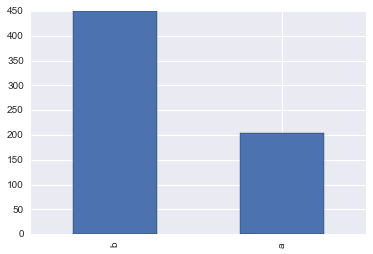

In [407]:
print "Attribute 0"
df[0].value_counts().plot(kind='bar')

With only two categories, this column isn't that interesting. Because the category only has two values, it's possible it represents male v female. With that being said, the occurances of each aren't even and column 'b' is more than twice as big as 'a' so I'm ruling out this column representing 'sex'.

Attribute 1


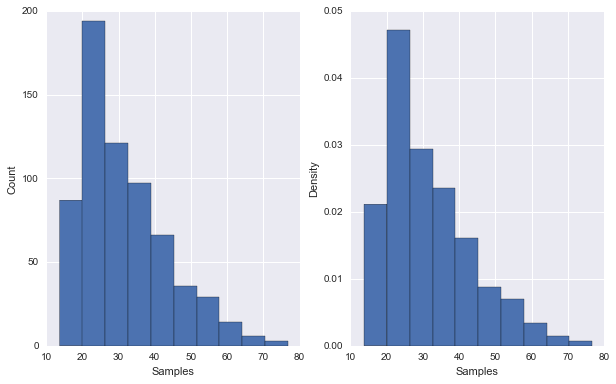

In [408]:
print "Attribute 1"
graph_histogram(df[1].as_matrix())

This looks a little like a beta distribution with alpha = 2 and beta = 5 or a gamma distribution with k and theta = 2. Given the min and max values and how the largest values occur between 25 and 40, this column may be age.

Attribute 2


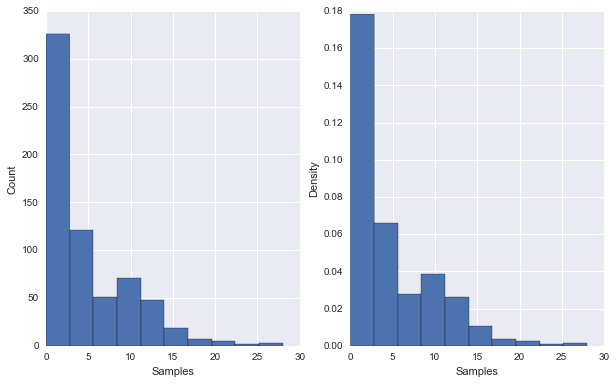

In [409]:
print "Attribute 2"
graph_histogram(df[2].as_matrix())

This looks a lot like an exponential distribution although I don't have any good guesses yet as to what this column could represent.

Attribute 3


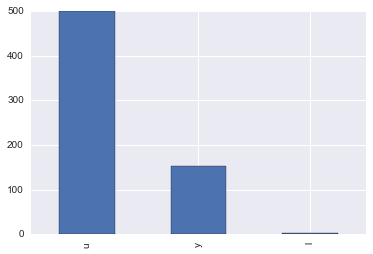

In [410]:
print "Attribute 3"
df[3].value_counts().plot(kind='bar')

This histogram doesn't help much but given its shape and number of categories, this may represent the categories of 'risk' of a borrow defaulting on a loan ('high', 'medium', 'low').

Attribute 4


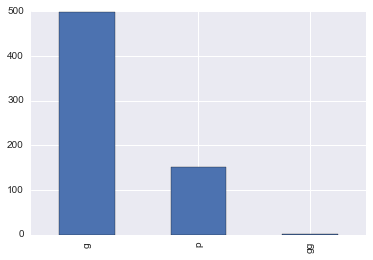

In [411]:
print "Attribute 4"
df[4].value_counts().plot(kind='bar')

I have the same thoughts as attribute 3. It's interesting to note that it appears attribute 4 values have the same exact count per category as attribute 4.

Attribute 5


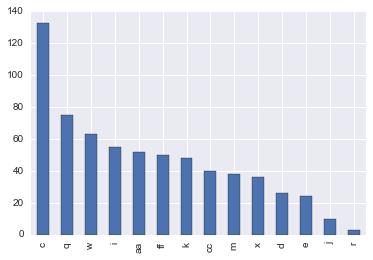

In [412]:
print "Attribute 5"
df[5].value_counts().plot(kind='bar')

No obvious guesses pop out at me, but this attribute looks to be relatively structured and has 14 categories.

To speed up processing, I'm only to comment on histograms that look interesting:

Attribute 6


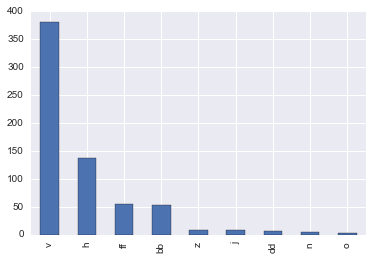

In [413]:
print "Attribute 6"
df[6].value_counts().plot(kind='bar')

Again, this looks like an exponential distribution, but I don't have an idea of what it could be.

Attribute 7


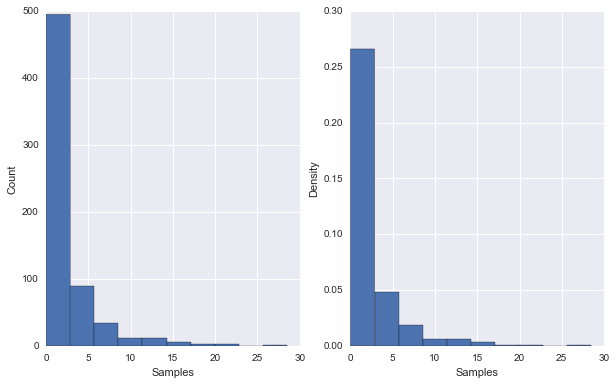

In [414]:
print "Attribute 7"
graph_histogram(df[7].as_matrix())

This attribute follows the distribution of attribute 2 and has the same min and max values.

Attribute 8


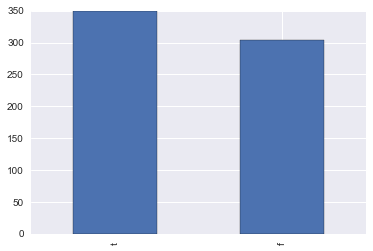

In [415]:
print "Attribute 8"
df[8].value_counts().plot(kind='bar')

This may be some kind of boolean field or could represent 'sex' due to how relatively balanced it is.

Attribute 9


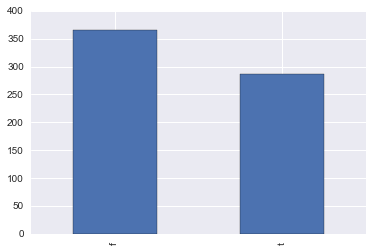

In [416]:
print "Attribute 9"
df[9].value_counts().plot(kind='bar')

This could also be a boolean field, but it is more imbalanced than attribute 8.

Attribute 10


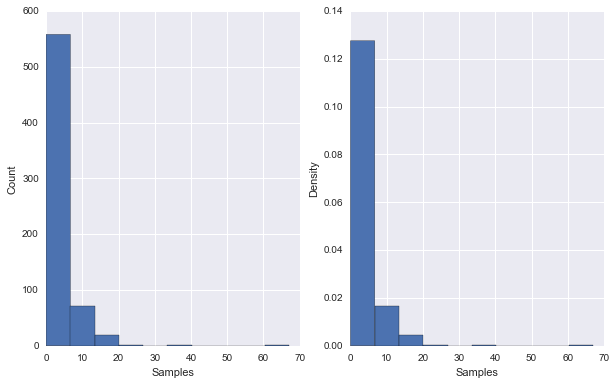

In [417]:
print "Attribute 10"
graph_histogram(df[10].as_matrix())

Another exponential distribution.

Attribute 11


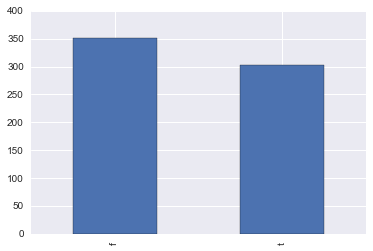

In [418]:
print "Attribute 11"
df[11].value_counts().plot(kind='bar')

Attribute 12


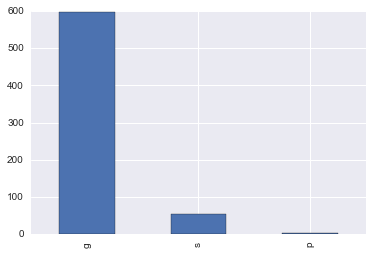

In [419]:
print "Attribute 12"
df[12].value_counts().plot(kind='bar')

Attribute 13


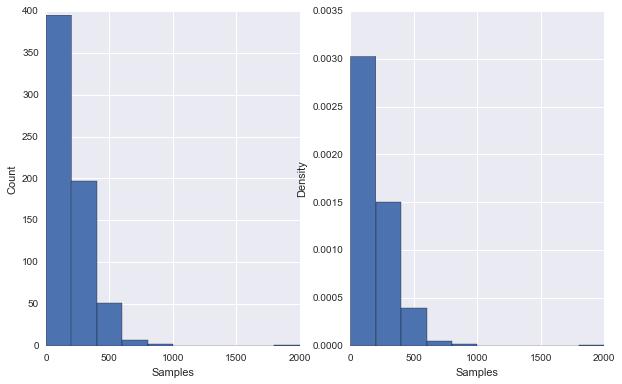

In [420]:
print "Attribute 13"
graph_histogram(df[13].as_matrix())

Yet another exponential distribution, although given the min and max value, this may be a down payment on the loan.

Attribute 14


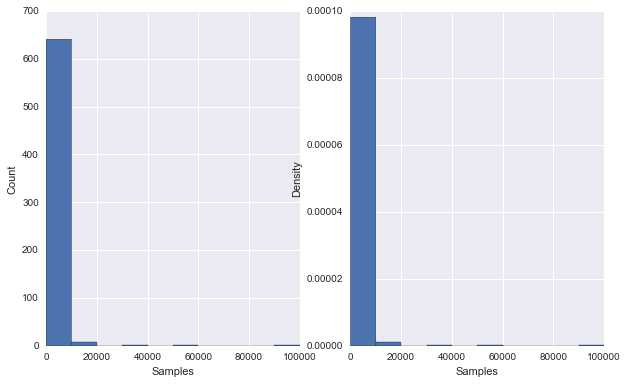

In [421]:
print "Attribute 14"
graph_histogram(df[14].as_matrix())

It's interesting how the values in attribute 14 are nearly all under 20000 with a few outliers up to 100000.

Let's produce some box-and-whisker plots for the numeric columns:

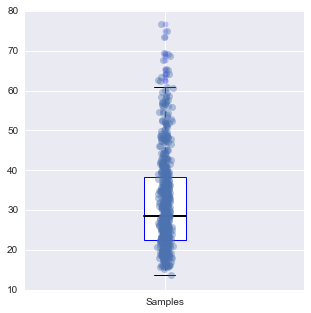

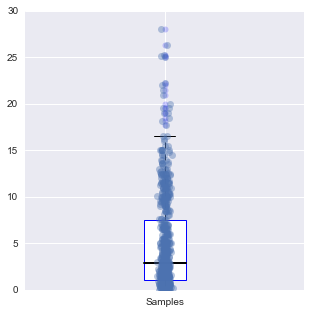

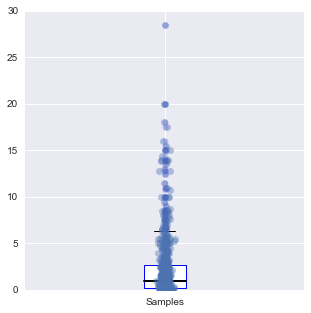

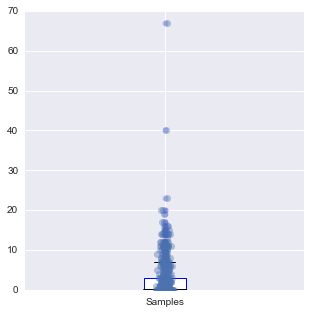

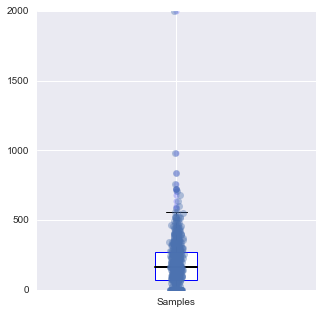

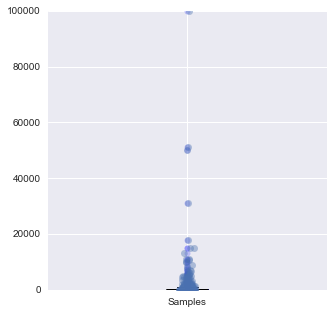

In [422]:
graph_boxplot(df[1])
graph_boxplot(df[2])
graph_boxplot(df[7])
graph_boxplot(df[10])
graph_boxplot(df[13])
graph_boxplot(df[14])

From these boxplots, we can see that attributes 1 and 2 are relatively smooth and look to contain no outliers. The others, on the other hand, suffer from quiet a few outliers, especially attributes 13 and 14.

Now that we have an idea of how each attribute 'looks', I'd like to try to discover some relationships that might exist between our attributes. Because of a lack of knowledge about what each column represents, I'm going to start by comparing each categorical attribute against the class label (attribute 15).

In [423]:
print "\nAttribute 0"
print pd.crosstab( df[0], df[15])
print "\nAttribute 3"
print pd.crosstab( df[3], df[15])
print "\nAttribute 4"
print pd.crosstab( df[4], df[15])
print "\nAttribute 5"
print pd.crosstab( df[5], df[15])
print "\nAttribute 6"
print pd.crosstab( df[6], df[15])
print "\nAttribute 8"
print pd.crosstab( df[8], df[15])
print "\nAttribute 9"
print pd.crosstab( df[9], df[15])
print "\nAttribute 11"
print pd.crosstab( df[11], df[15])
print "\nAttribute 12"
print pd.crosstab( df[12], df[15])


Attribute 0
15    +    -
0           
a    95  108
b   201  249

Attribute 3
15    +    -
3           
l     2    0
u   249  250
y    45  107

Attribute 4
15    +    -
4           
g   249  250
gg    2    0
p    45  107

Attribute 5
15   +   -
5         
aa  19  33
c   60  73
cc  29  11
d    7  19
e   14  10
ff   7  43
i   14  41
j    3   7
k   13  35
m   16  22
q   49  26
r    2   1
w   33  30
x   30   6

Attribute 6
15    +    -
6           
bb   24   29
dd    2    4
ff    8   46
h    87   50
j     3    5
n     2    2
o     1    1
v   163  218
z     6    2

Attribute 8
15    +    -
8           
f    18  286
t   278   71

Attribute 9
15    +    -
9           
f    93  273
t   203   84

Attribute 11
15    +    -
11          
f   151  200
t   145  157

Attribute 12
15    +    -
12          
g   280  318
p     1    1
s    15   38


There doesn't seem to be a strong relationship between any single categorical attribute and the outcome of being approved or denied a loan. Let's try a similar analysis for the numerical attribute.

In [424]:
for attr in [1, 2, 7, 10, 13, 14]:
    print "\nAttribute %d" % attr
    grouped = df.groupby(15)
    grouping = grouped[1].describe()
    grouping = grouping.unstack( level=-1)
    print grouping


Attribute 1
    count       mean        std    min    25%    50%    75%    max
15                                                                
+   296.0  33.845473  12.689357  13.75  23.25  31.04  41.44  76.75
-   357.0  29.562269  10.719168  15.17  21.92  26.92  34.83  74.83

Attribute 2
    count       mean        std    min    25%    50%    75%    max
15                                                                
+   296.0  33.845473  12.689357  13.75  23.25  31.04  41.44  76.75
-   357.0  29.562269  10.719168  15.17  21.92  26.92  34.83  74.83

Attribute 7
    count       mean        std    min    25%    50%    75%    max
15                                                                
+   296.0  33.845473  12.689357  13.75  23.25  31.04  41.44  76.75
-   357.0  29.562269  10.719168  15.17  21.92  26.92  34.83  74.83

Attribute 10
    count       mean        std    min    25%    50%    75%    max
15                                                                
+   296.0

Based on the difference between the means of the attribute given a '+' or '-' label and the standard deviation it looks like attributes 7, 10, and 14 could be good attributes to include in the model. The other attributes all have relatively similar means regardless of their label or their 50% quartile's are too close.

Since this grouping analysis isn't limited to numerical attributes, let's see how the categorical attributes do:

In [425]:
for attr in [0, 3, 4, 5, 6, 8, 9, 11, 12]:
    print "\nAttribute %d" % attr
    grouped = df.groupby(15)
    grouping = grouped[attr].value_counts()
    grouping = grouping.unstack( level=-1)
    print grouping


Attribute 0
0     a    b
15          
+    95  201
-   108  249

Attribute 3
3     l      u      y
15                   
+   2.0  249.0   45.0
-   NaN  250.0  107.0

Attribute 4
4       g   gg      p
15                   
+   249.0  2.0   45.0
-   250.0  NaN  107.0

Attribute 5
5   aa   c  cc   d   e  ff   i  j   k   m   q  r   w   x
15                                                      
+   19  60  29   7  14   7  14  3  13  16  49  2  33  30
-   33  73  11  19  10  43  41  7  35  22  26  1  30   6

Attribute 6
6   bb  dd  ff   h  j  n  o    v  z
15                                 
+   24   2   8  87  3  2  1  163  6
-   29   4  46  50  5  2  1  218  2

Attribute 8
8     f    t
15          
+    18  278
-   286   71

Attribute 9
9     f    t
15          
+    93  203
-   273   84

Attribute 11
11    f    t
15          
+   151  145
-   200  157

Attribute 12
12    g  p   s
15            
+   280  1  15
-   318  1  38


Based on the splits above, it looks like attributes 5, 6, 8, and 9 may have an influence on the class label. For these attributes, we see data instances with a particular category value gravitate towards a specific class label.

This completes the EDA portion of the project. With the information gleaned from EDA, we can start proposing models. First, I want to compare a model that uses every attribute with the attributes I identified as interesting. Let's start by generating the model with every attribute. First we need to encode the categorical attributes using a one hot encoding.

In [426]:
# Category columns
cate_colms = [0, 3, 4, 5, 6, 8, 9, 11, 12]

# Replace category strings with ints
for cate_colm in cate_colms:
    encoding = 0
    for val in df[cate_colm].unique():
        df[cate_colm].replace(val, encoding, inplace=True)
        encoding += 1
df.replace('+', 1, inplace=True)
df.replace('-', 0, inplace=True)

# Use one hot encoding to encode categorical attributes
enc = OneHotEncoder(categorical_features=cate_colms)
df = pd.DataFrame(enc.fit_transform(df.as_matrix()).toarray())
print enc.feature_indices_ 

# Change column names
columns = []
idx = 0
for column in df:
    columns.append("attr_%d" % idx)
    idx += 1
df.columns = columns
print df.head()

[ 0  2  5  8 22 31 33 35 37 40]
   attr_0  attr_1  attr_2  attr_3  attr_4  attr_5  attr_6  attr_7  attr_8  \
0     1.0     0.0     1.0     0.0     0.0     1.0     0.0     0.0     1.0   
1     0.0     1.0     1.0     0.0     0.0     1.0     0.0     0.0     0.0   
2     0.0     1.0     1.0     0.0     0.0     1.0     0.0     0.0     0.0   
3     1.0     0.0     1.0     0.0     0.0     1.0     0.0     0.0     1.0   
4     1.0     0.0     1.0     0.0     0.0     1.0     0.0     0.0     1.0   

   attr_9   ...     attr_37  attr_38  attr_39  attr_40  attr_41  attr_42  \
0     0.0   ...         1.0      0.0      0.0    30.83    0.000     1.25   
1     1.0   ...         1.0      0.0      0.0    58.67    4.460     3.04   
2     1.0   ...         1.0      0.0      0.0    24.50    0.500     1.50   
3     0.0   ...         1.0      0.0      0.0    27.83    1.540     3.75   
4     0.0   ...         0.0      1.0      0.0    20.17    5.625     1.71   

   attr_43  attr_44  attr_45  attr_46  
0      1

In [427]:
formula = "attr_46 ~ attr_0"
for column in df.columns[1:-1]:
    formula += " + " + column
result = bootstrap_logm(formula, data=df)
describe_bootstrap_fit(result)

regression:  attr_46 ~ attr_0 + attr_1 + attr_2 + attr_3 + attr_4 + attr_5 + attr_6 + attr_7 + attr_8 + attr_9 + attr_10 + attr_11 + attr_12 + attr_13 + attr_14 + attr_15 + attr_16 + attr_17 + attr_18 + attr_19 + attr_20 + attr_21 + attr_22 + attr_23 + attr_24 + attr_25 + attr_26 + attr_27 + attr_28 + attr_29 + attr_30 + attr_31 + attr_32 + attr_33 + attr_34 + attr_35 + attr_36 + attr_37 + attr_38 + attr_39 + attr_40 + attr_41 + attr_42 + attr_43 + attr_44 + attr_45
n:  653
----------
intercept:  -0.0733849388776 [-0.428369567846708, 0.08749473001212058]
attr_0:  -0.0228006414276 [-0.34287566200557573, 0.1980312298555822]
attr_1:  -0.0505842974501 [-0.33801231780598795, 0.20125116310566388]
attr_2:  -0.1155397916 [-0.296610740881851, 0.15993821298805816]
attr_3:  -0.472910874128 [-0.6229105237780683, -0.1406704891354616]
attr_4:  0.51506572685 [0.0, 0.7450611236953029]
attr_5:  -0.1155397916 [-0.296610740881851, 0.15993821298805816]
attr_6:  -0.472910874128 [-0.6229105237780683, -0.140

In [428]:
original_interesting_attributes = [5, 6, 8, 9, 7, 10, 14]
original_categorial_attributes = [0, 3, 4, 5, 6, 8, 9, 11, 12]
other_attributes = list(set([i for i in xrange(15)]) - set(original_categorial_attributes))
start_index = [0, 2, 5, 8, 22, 31, 33, 35, 37, 40]
formula = "attr_46~"
for attr in original_interesting_attributes:
    if attr in original_categorial_attributes:
        idx = original_categorial_attributes.index(attr)
        start_idx = start_index[idx]
        end_idx = start_index[idx + 1]
        for idx in xrange(start_idx, end_idx):
            formula += "attr_%d+" % idx
    else:
        idx = other_attributes.index(attr)
        formula += "attr_%d+" % (start_index[-1] + idx)
if formula[-1] == '+':
    formula = formula[:-1]
result = bootstrap_logm(formula, data=df)
describe_bootstrap_fit(result)

regression:  attr_46~attr_8+attr_9+attr_10+attr_11+attr_12+attr_13+attr_14+attr_15+attr_16+attr_17+attr_18+attr_19+attr_20+attr_21+attr_22+attr_23+attr_24+attr_25+attr_26+attr_27+attr_28+attr_29+attr_30+attr_31+attr_32+attr_33+attr_34+attr_42+attr_43+attr_45
n:  653
----------
intercept:  -0.537412688822 [-0.7304806731176409, -0.3639096388451804]
attr_8:  0.284831829482 [-0.2569080075331037, 0.8105989010060068]
attr_9:  0.0893253991456 [-0.33344667881304946, 0.7080616232884458]
attr_10:  -0.169944043426 [-0.7395349484885905, 0.30838021098467683]
attr_11:  0.000854598526272 [-0.06722935190088383, 0.07649190405237374]
attr_12:  0.530476948341 [0.13842864084467457, 1.4362804711160275]
attr_13:  -0.437577534755 [-1.083811104965826, 0.056060331945530006]
attr_14:  -0.00955185097957 [-0.5964591060757698, 0.36833953840245937]
attr_15:  0.0365904009176 [-0.3111127378716255, 0.6111950604037335]
attr_16:  0.620469161056 [0.09005626328977474, 1.5934810541372506]
attr_17:  -0.500434962582 [-1.1319

Unfortuantely, not having column names means we can't compare our expectations of the signs of the betas to the actual signs we got. This makes it difficult to adjust my guess of attributes that will be useful for the model. As a result, I have to rely on the 'interesting' attributes I identified during the EDA phase of the project. 

With that being said, my handpicked attributes outperformed the model that used every attribute by 2%.

Another possible combination of attributes is to remove the attributes with 0 in the confidence interval. This assumes the worst case that attributes with 0 in their confidence intervals aren't needed in the model. Doing this gets me:

In [429]:
formula = "attr_46~attr_12+attr_16+attr_17+attr_20+attr_31+attr_32+attr_34+attr_43+attr_45"
result = bootstrap_logm(formula, data=df)
describe_bootstrap_fit(result)

regression:  attr_46~attr_12+attr_16+attr_17+attr_20+attr_31+attr_32+attr_34+attr_43+attr_45
n:  653
----------
intercept:  -0.513824864505 [-0.789499429064038, -0.2571592225687961]
attr_12:  0.673033808355 [0.04766302036353323, 1.3742605008921172]
attr_16:  0.77645829711 [0.22666043421397689, 1.374514879778806]
attr_17:  -0.544881074664 [-1.1033699665594046, 0.12345661621290921]
attr_20:  -0.968104600855 [-1.5325413109427752, -0.3475136385936937]
attr_31:  1.44533244708 [1.217322829835238, 1.6872491220544377]
attr_32:  -1.95915731159 [-2.2355233506475116, -1.6744740601638677]
attr_34:  -0.528643379981 [-0.9942185273672327, -0.042240332593528065]
attr_43:  0.125512571409 [0.058885814991525225, 0.23514733764481227]
attr_45:  0.000503798766664 [0.0002582363977940553, 0.0007752725213329627]
Accuracy: 13.016845%


This is still an improvement over using all the attributes but doesn't perform as well as my handpicked attributes. Next we can try a model that just uses non-categorical attributes. This gets us:

In [430]:
formula = "attr_46~attr_40+attr_41+attr_42+attr_43+attr_44+attr_45"
result = bootstrap_logm(formula, data=df)
describe_bootstrap_fit(result)

regression:  attr_46~attr_40+attr_41+attr_42+attr_43+attr_44+attr_45
n:  653
----------
intercept:  -1.34063685026 [-1.8318780270017578, -0.36975491117583104]
attr_40:  -0.00348751728413 [-0.02826492431662158, 0.01212729161458533]
attr_41:  0.030061133289 [-0.01690148843706598, 0.07166482412289174]
attr_42:  0.233548688129 [0.17714311379021558, 0.35399254313797757]
attr_43:  0.30425255307 [0.23138693298143514, 0.47378376354692675]
attr_44:  -0.000772755692711 [-0.001984076181845663, 0.0004330787968471321]
attr_45:  0.000491378645501 [0.00033732329555863523, 0.0008718114166584015]
Accuracy: 23.124043%


Even though this was a shot in the dark, this produced the best performing model so far. In a forward-stepwise feature selection manner, let's add one of each categorical feature to this model and grade performance:

In [431]:
formula = "attr_46~attr_40+attr_41+attr_42+attr_43+attr_44+attr_45"
for idx,attr in enumerate(start_index):
    if len(start_index) > idx + 1:
        working_formula = formula
        for i in xrange(start_index[idx], start_index[idx+1]):
            working_formula += "+attr_%d" % i
        result = bootstrap_logm(working_formula, data=df)
        describe_bootstrap_fit(result)
        print '\n'

regression:  attr_46~attr_40+attr_41+attr_42+attr_43+attr_44+attr_45+attr_0+attr_1
n:  653
----------
intercept:  -0.772510190323 [-1.318782429648778, -0.42844357304590375]
attr_40:  -0.00814839618472 [-0.02510779469692786, 0.012368225327546466]
attr_41:  0.0260902846021 [-0.013779191168229794, 0.06151448981686111]
attr_42:  0.247058238428 [0.14917599717459293, 0.35765747775613266]
attr_43:  0.309813030699 [0.22187846957767926, 0.4469455562738295]
attr_44:  -0.000891716725267 [-0.0022702560884483207, 0.0005714471847388591]
attr_45:  0.000489581804232 [0.0003259084974009775, 0.0008461640859424162]
attr_0:  -0.434080724481 [-0.7545744821634317, -0.164098151471274]
attr_1:  -0.338429465842 [-0.6745491118842142, -0.14451222893009588]
Accuracy: 22.970904%


regression:  attr_46~attr_40+attr_41+attr_42+attr_43+attr_44+attr_45+attr_2+attr_3+attr_4
n:  653
----------
intercept:  -0.828990007171 [-1.365759522899244, -0.38064413417528586]
attr_40:  -0.00806287425359 [-0.027979825348608475, 0.010

Let's continue this until no addition improves the best performance:

In [432]:
formula = "attr_46~attr_40+attr_41+attr_42+attr_43+attr_44+attr_45+attr_35+attr_36"
for idx,attr in enumerate(start_index):
    if len(start_index) > idx + 1:
        working_formula = formula
        for i in xrange(start_index[idx], start_index[idx+1]):
            if i != 35 and i != 36:
                working_formula += "+attr_%d" % i
        result = bootstrap_logm(working_formula, data=df)
        describe_bootstrap_fit(result)
        print '\n'

regression:  attr_46~attr_40+attr_41+attr_42+attr_43+attr_44+attr_45+attr_35+attr_36+attr_0+attr_1
n:  653
----------
intercept:  -0.707701074033 [-0.9876402502159319, -0.36893234826982824]
attr_40:  -0.00228570799979 [-0.020814650461589264, 0.016458129085789232]
attr_41:  0.0304858604985 [-0.015583579115669384, 0.0698096690814218]
attr_42:  0.240797765677 [0.15855808781221103, 0.3386071252614927]
attr_43:  0.315221320627 [0.21384703094766083, 0.4095669974121755]
attr_44:  -0.000687764193511 [-0.0025913086497971797, 0.00047664088769093504]
attr_45:  0.00049402737841 [0.00032679810850552954, 0.0008220126992505955]
attr_35:  -0.346834603062 [-0.5761257301251437, -0.16464139551547163]
attr_36:  -0.36086647097 [-0.6292650699957747, -0.0830436556184775]
attr_0:  -0.394771856788 [-0.6412695263056909, -0.1390935217739881]
attr_1:  -0.312929217245 [-0.5431223709256838, 0.022581218706769657]
Accuracy: 23.124043%


regression:  attr_46~attr_40+attr_41+attr_42+attr_43+attr_44+attr_45+attr_35+attr

In [433]:
formula = "attr_46~attr_40+attr_41+attr_42+attr_43+attr_44+attr_45+attr_35+attr_36+attr_37+attr_38+attr_39+attr_0+attr_1"
for idx,attr in enumerate(start_index):
    if len(start_index) > idx + 1:
        working_formula = formula
        for i in xrange(start_index[idx], start_index[idx+1]):
            if i not in [35, 36, 37, 38, 39, 0, 1]:
                working_formula += "+attr_%d" % i
        result = bootstrap_logm(working_formula, data=df)
        describe_bootstrap_fit(result)
        print '\n'

regression:  attr_46~attr_40+attr_41+attr_42+attr_43+attr_44+attr_45+attr_35+attr_36+attr_37+attr_38+attr_39+attr_0+attr_1
n:  653
----------
intercept:  -0.583148292804 [-0.849968700398382, -0.27523859199637557]
attr_40:  -0.00210918265057 [-0.021551346606130468, 0.016127666150767557]
attr_41:  0.0303427339704 [-0.011194982145812493, 0.07318592411497517]
attr_42:  0.239668172658 [0.14564292445692695, 0.3699778542085361]
attr_43:  0.313959157619 [0.24026365328349444, 0.45672214506187236]
attr_44:  -0.000682902679523 [-0.0016749792242048169, 0.0007009462382154446]
attr_45:  0.00049234252484 [0.00031557749947956756, 0.0009189118451290703]
attr_35:  -0.286917461195 [-0.5370620917470699, -0.06165331307575486]
attr_36:  -0.296230831609 [-0.5467321544393942, -0.045328784498862955]
attr_37:  -0.247691131757 [-0.5950391987692683, 0.0017919068160878037]
attr_38:  -0.297354813937 [-0.6907928583211836, 0.0815945597324376]
attr_39:  -0.0381023471102 [-0.12466695376904943, 1.4305187474515632e-10]
a

The best performance we settled at was an accuracy of 23.12% with the model: attr_46~attr_40+attr_41+attr_42+attr_43+attr_44+attr_45+attr_35+attr_36+attr_37+attr_38+attr_39+attr_0+attr_1.

Let's have a look at an interpretation of the result model's coefficients. Below is a rundown of what a unit change for each attribute in the model has on the P(Y = 1). This allows us to interpret each coefficient as, with all things being equal, a unit increase of each attribute affects the P(Y = 1) as such:

In [434]:
# Interpreting coefficients
# Increase attr_40 by 1 unit
selected_attrs = ["attr_40", "attr_41", "attr_42", "attr_43", "attr_44", "attr_45", "attr_35", "attr_36", "attr_37", "attr_38", "attr_39", "attr_0", "attr_1"]
means = df[selected_attrs].mean()
for attr in selected_attrs:
    print "Testing a unit increase of %s" % attr
    around_mean = logistic(result["coefficients"][0] + np.dot(result["coefficients"][1:], means))
    means[attr] += 1
    moved_one_unit = logistic(result["coefficients"][0] + np.dot(result["coefficients"][1:], means))
    print "P(y = 1) = ", around_mean
    print "P(y = 1) = after 1 unit increase to %s = %f" % (attr, moved_one_unit)
    print "Difference of ", moved_one_unit - around_mean
    print "\n"
    means[attr] -= 1

Testing a unit increase of attr_40
P(y = 1) =  0.586111887256
P(y = 1) = after 1 unit increase to attr_40 = 0.585600
Difference of  -0.000511748287885


Testing a unit increase of attr_41
P(y = 1) =  0.586111887256
P(y = 1) = after 1 unit increase to attr_41 = 0.593453
Difference of  0.0073409401816


Testing a unit increase of attr_42
P(y = 1) =  0.586111887256
P(y = 1) = after 1 unit increase to attr_42 = 0.642810
Difference of  0.0566985402864


Testing a unit increase of attr_43
P(y = 1) =  0.586111887256
P(y = 1) = after 1 unit increase to attr_43 = 0.659681
Difference of  0.0735693850247


Testing a unit increase of attr_44
P(y = 1) =  0.586111887256
P(y = 1) = after 1 unit increase to attr_44 = 0.585946
Difference of  -0.000165671506966


Testing a unit increase of attr_45
P(y = 1) =  0.586111887256
P(y = 1) = after 1 unit increase to attr_45 = 0.586231
Difference of  0.000119429718974


Testing a unit increase of attr_35
P(y = 1) =  0.586111887256
P(y = 1) = after 1 unit increa

Next, let's take a look at the learning curves for this model and see where we are on the bias/variance tradeoff and whether more data will help:

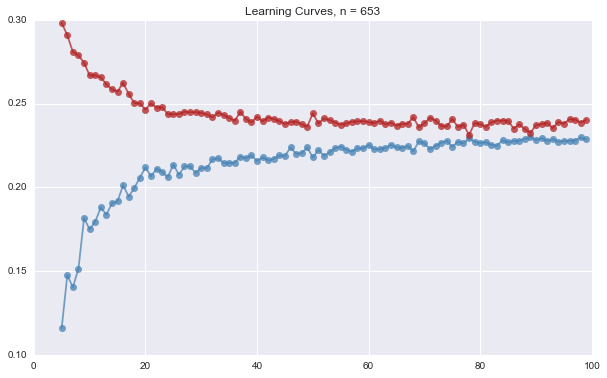

In [435]:
train_mean_mse = []
test_mean_mse = []
selected_attrs.append("attr_46")
instances = df[selected_attrs].as_matrix()
data_indices = [i for i in xrange(0, instances.shape[0])]
for chunk in xrange(5, 100):
    train_chunk_error = []
    test_chunk_error = []
    for iteration in xrange(1, 100):
        # Shuffle the data instances so we get new ones each time
        np.random.shuffle(instances)
        # Split data into training and test set
        train_indices = data_indices[:(int(0.80 * (instances.shape[0] * (chunk / 100))))]
        test_indices = data_indices[(int(0.80 * instances.shape[0] * (chunk / 100)) + 1):]
        # Train model
        model = linear.LogisticRegression(fit_intercept=False).fit(
            instances[train_indices, :-1], instances[train_indices, -1])
        # Predict
        train_predictions = model.predict(instances[train_indices, :-1])
        test_predictions = model.predict(instances[test_indices, :-1])
        # Calculate MSE
        train_mse = sum(train_predictions != instances[train_indices, -1]) / len(train_predictions)
        test_mse = sum(test_predictions != instances[test_indices, -1]) / len(test_predictions)
        train_chunk_error.append(train_mse)
        test_chunk_error.append(test_mse)
    train_mean_mse.append(np.mean(train_chunk_error))
    test_mean_mse.append(np.mean(test_chunk_error))
    
figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot([i for i in xrange(5,100)], train_mean_mse, 'o-', color="steelblue", alpha=0.75)
axes.plot([i for i in xrange(5,100)], test_mean_mse, "o-", color="firebrick", alpha=0.75)
axes.set_title( "Learning Curves, n = 653")

The two curves of the learning curve plot converge after using about 60% of the total availble data so getting more data probably won't help the model. As for the validation curve:

[0.23659003831417624, 0.22885057471264367]
[0.48373288269914344, 0.48499679505856297]


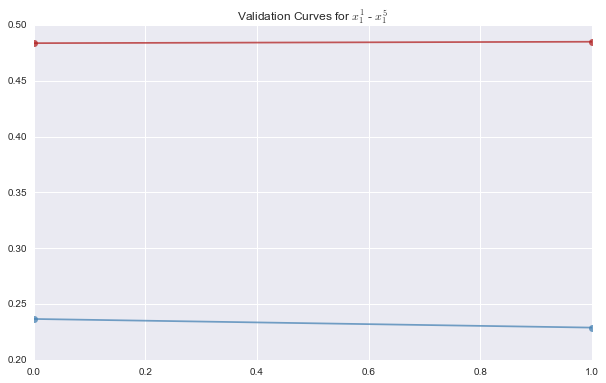

In [436]:
from copy import deepcopy

def cross_validate( formula, data, test_size=0.20, change_threshold=False):
    training_mses = []
    test_mses = []
    
    n = data.shape[ 0]
    test_n = int( np.round( test_size * n, 0))

    indices = deepcopy( data.index).values
    py_random.shuffle( indices)

    test_indices = indices[ 0:test_n]
    training_indices = indices[test_n:]

    test_set = data.ix[ test_indices]
    training_set = data.ix[ training_indices]

    y, X = patsy.dmatrices( formula, training_set, return_type="matrix")
    y = y.ravel()
    if change_threshold:
        model = linear.LogisticRegression(fit_intercept=False, class_weight= {0: 0.54, 1: 0.46}).fit( X, y)
    else:
        model = linear.LogisticRegression(fit_intercept=False).fit( X, y)
    y_hat = model.predict( X)

    training_mse = sum(y_hat != y) / len(y_hat)

    y, X = patsy.dmatrices( formula, test_set, return_type="matrix")
    y_hat = model.predict( X)

    test_mse = sum(y_hat != y) / len(y_hat)

    return training_mse, test_mse

def validation_curves( formulas, data, iterations=100, test_size=0.2):
    train = []
    test = []
    for change in [True, False]:
        train_chunk = []
        test_chunk = []
        for i in range( iterations):
            train_mse, test_mse = cross_validate( formula, data, test_size=test_size, change_threshold=change)
            train_chunk.append( train_mse)
            test_chunk.append( test_mse)
        train.append( np.mean( train_chunk))
        test.append( np.mean( test_chunk))
    print train
    print test
    return train, test

train, test = validation_curves(["attr_46~attr_40+attr_41+attr_42+attr_43+attr_44+attr_45+attr_35+attr_36+attr_37+attr_38+attr_39+attr_0+attr_1"], df)

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( [0, 1], train, 'o-', color="steelblue", alpha=0.75)
axes.plot( [0, 1], test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Validation Curves for $x_1^1$ - $x_1^5$")

From the above validation curves where I updated the threshold to 0.54, we can see the tweaking the threshold to closer match the actual distribution of classes very slightly improves generalization error.